<div id = 'goal'
     style="font-family: Calibri, serif; text-align: left;">
    <hr style="border: none; 
               border-top: 2.85px solid blue; 
               width: 100%; 
               margin-top: 62px;
               margin-bottom: auto;
               margin-left: 0;">
    <div style="font-size: 38px; letter-spacing: 2.25px;"><b>Nhận Diện Các Loại Bệnh Thường Gặp Trên Ngô Thông Qua Lá Cây

In [1]:
!nvidia-smi

Mon May 26 14:33:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import thư viện

In [65]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random

import os
import shutil
from PIL import Image                                     # Thư viện xử lý ảnh (Pillow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img  
                                                         # Các hàm xử lý ảnh của Keras: tăng cường dữ liệu, đọc ảnh, chuyển đổi định dạng ảnh

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

In [5]:
# Import Keras
from keras.models import Sequential                          # Mô hình mạng nơ-ron dạng chuỗi các lớp
from keras.layers import Conv2D                              # Lớp tích chập (Convolutional layer)
from keras.layers import MaxPooling2D                        # Lớp lấy giá trị lớn nhất trong vùng (Max pooling)
from keras.layers import Flatten                             # Lớp làm phẳng mảng 2D để đưa vào lớp fully-connected
from keras.layers import Dense                               # Lớp fully-connected (kết nối đầy đủ)
from keras.layers import Dropout                             # Lớp dropout giúp tránh overfitting bằng cách ngẫu nhiên bỏ bớt neuron
from keras.layers import BatchNormalization                  # Lớp chuẩn hóa đầu ra neuron
from keras.layers import Activation                          # Lớp áp dụng hàm kích hoạt
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Callback dùng để dừng training sớm và lưu trọng số mô hình tốt nhất
from keras.models import load_model                          # Hàm dùng để tải mô hình đã được huấn luyện
# Lớp tiền xử lý dữ liệu
from keras.layers import Rescaling                           # Lớp chuẩn hóa lại giá trị pixel ảnh

# Import TensorFlow
import tensorflow as tf

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [7]:
# working_dir = '/kaggle/working'

# for filename in os.listdir(working_dir):
#     file_path = os.path.join(working_dir, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.remove(file_path)
#             print(f"Đã xóa file: {file_path}")
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#             print(f"Đã xóa thư mục: {file_path}")
#     except Exception as e:
#         print(f"Lỗi khi xóa {file_path}: {e}")


In [8]:
# split_dir = "/kaggle/working/split_data"

# # Kiểm tra và xóa nếu tồn tại
# if os.path.exists(split_dir):
#     shutil.rmtree(split_dir)
#     print(f"Đã xóa thư mục: {split_dir}")
# else:
#     print(fThư mục không tồn tại: {split_dir}")


In [9]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'
#colormap = 
#template = 

 <p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Kiểm tra xem có đang chạy gpu ko</p>

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Thiết lập chiến lược sử dụng GPU đầu tiên
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  
        print('Đang dùng GPU')
    except RuntimeError as e:

        print(e)

Đang dùng GPU


# Exploring the Data (Khám phá dữ liệu)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Tải bộ dữ liệu.</p>

In [12]:
base_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"
output_dir = "/kaggle/working/data"
os.makedirs(output_dir, exist_ok=True)

# Lấy danh sách các nhãn
classes = os.listdir(base_dir)
print("Các nhãn:", classes)

count = 0
# chuyển toàn bộ ảnh sang output_dir
for cls in classes:
    src_cls_dir = os.path.join(base_dir, cls)
    dst_cls_dir = os.path.join(output_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    images = os.listdir(src_cls_dir)
    count += len(images)
    for img in images:
        src_path = os.path.join(src_cls_dir, img)
        dst_path = os.path.join(dst_cls_dir, img)
        shutil.copy2(src_path, dst_path)

    print(f"Có {len(images)} ảnh trong nhãn '{cls}'.")
print(f"Dữ liệu có tổng cộng {count} ảnh")

Các nhãn: ['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']
Có 1306 ảnh trong nhãn 'Common_Rust'.
Có 1146 ảnh trong nhãn 'Blight'.
Có 1162 ảnh trong nhãn 'Healthy'.
Có 574 ảnh trong nhãn 'Gray_Leaf_Spot'.
Dữ liệu có tổng cộng 4188 ảnh


In [13]:
data_dir = "/kaggle/working/data"

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Có tổng cộng <b>4.188</b> ảnh trong tập dữ liệu tuy nhiên dữ liệu bị mất cân bằng ở nhãn Gray_Leaf_Spot khi nhãn này ít hơn 3 nhãn còn lại rất nhiều.</p>


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Mạng Nơ-ron Tích Chập (Convolutional Neural Networks) yêu cầu một kích thước cố định cho tất cả các hình ảnh mà chúng ta đưa vào. Chúng ta cũng có thể kiểm tra xem dữ liệu có đáp ứng yêu cầu này hay không.</p>
          


In [14]:
# Kiểm tra kích thước của tất cả ảnh trong dataset
unique_sizes = set()

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            unique_sizes.add(img.size)

print(f"\nTổng số kích thước ảnh khác nhau: {len(unique_sizes)}")
# print("\nCác kích thước ảnh trong dataset:")
# for size in sorted(unique_sizes):
#     print(f"- {size}")


Tổng số kích thước ảnh khác nhau: 266



Vẽ biểu đồ phân bố...


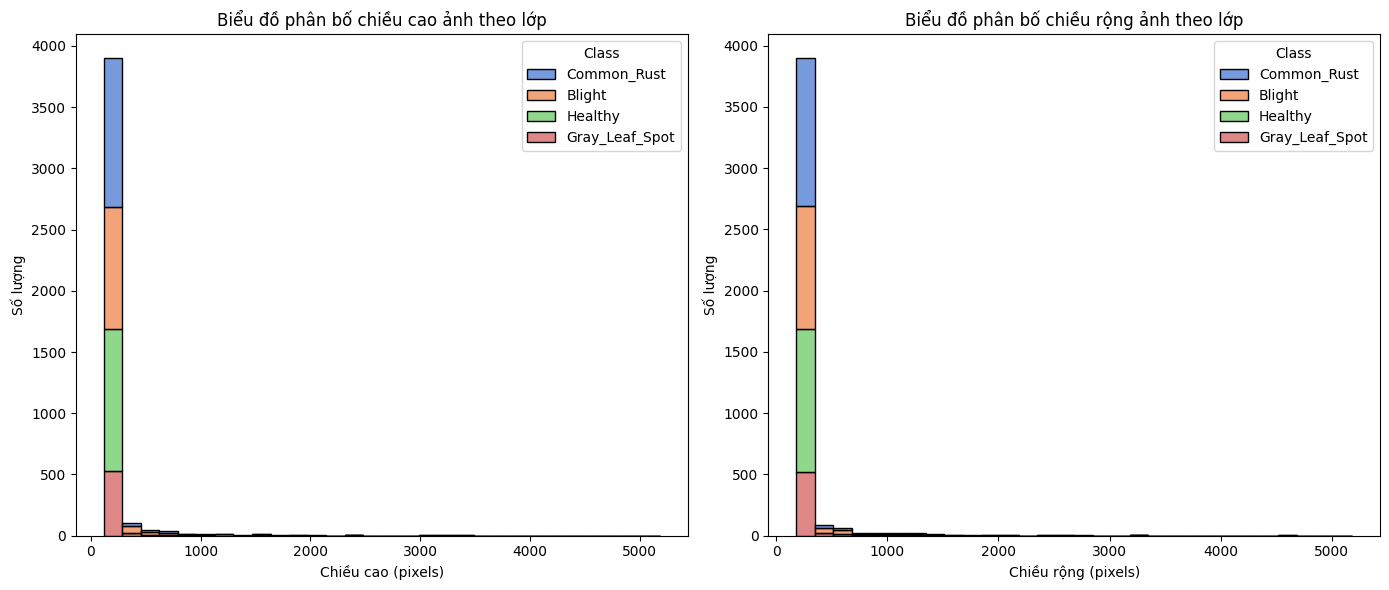


Vẽ biểu đồ phân tán...


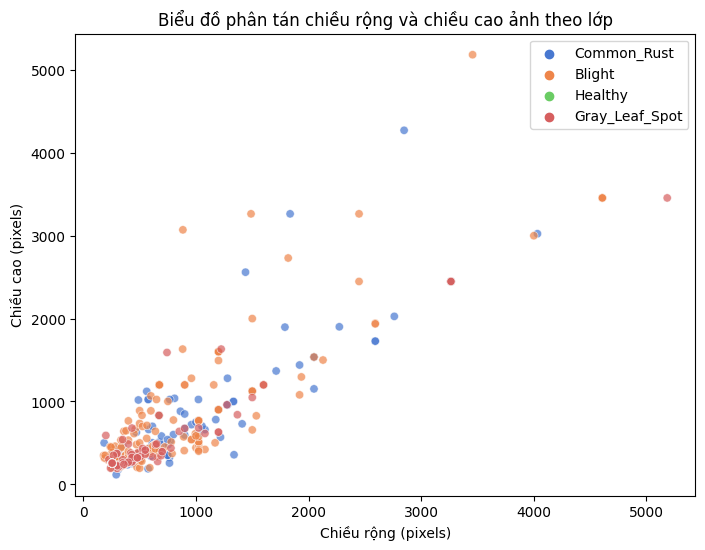

In [15]:
# Hàm thu thập thống kê kích thước ảnh
def collect_image_statistics(data_dir, classes):
    img_sizes = defaultdict(list)
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            with Image.open(img_path) as img:
                width, height = img.size
                img_sizes['Class'].append(cls)
                img_sizes['Height'].append(height)
                img_sizes['Width'].append(width)
    return pd.DataFrame(img_sizes)

# Hàm vẽ biểu đồ histogram cho chiều cao và chiều rộng
def plot_histograms(df):
    plt.figure(figsize=(14, 6))
    
    # Histogram cho chiều cao
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='Height', hue='Class', multiple='stack', palette='muted', bins=30)
    plt.title('Biểu đồ phân bố chiều cao ảnh theo lớp')
    plt.xlabel('Chiều cao (pixels)')
    plt.ylabel('Số lượng')
    
    # Histogram cho chiều rộng
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='Width', hue='Class', multiple='stack', palette='muted', bins=30)
    plt.title('Biểu đồ phân bố chiều rộng ảnh theo lớp')
    plt.xlabel('Chiều rộng (pixels)')
    plt.ylabel('Số lượng')
    
    plt.tight_layout()
    plt.show()

# Hàm vẽ biểu đồ scatter plot cho chiều cao và chiều rộng
def plot_scatter(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Width', y='Height', hue='Class', alpha=0.7, palette='muted')
    plt.title('Biểu đồ phân tán chiều rộng và chiều cao ảnh theo lớp')
    plt.xlabel('Chiều rộng (pixels)')
    plt.ylabel('Chiều cao (pixels)')
    plt.legend(loc='upper right')
    plt.show()

df_img_sizes = collect_image_statistics(data_dir, classes)

print("\nVẽ biểu đồ phân bố...")
plot_histograms(df_img_sizes)

print("\nVẽ biểu đồ phân tán...")
plot_scatter(df_img_sizes)

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Các hình ảnh có rất nhiều kích thước khác nhau. Phần lớn hình ảnh ở tất cả các lớp đều có kích thước nhỏ, tập trung chủ yếu trong khoảng 256x256 pixel. Các lớp Blight và Common_Rust thể hiện sự dao động lớn hơn về kích thước ảnh, với một số ảnh ngoại lệ có giá trị pixel rất cao.</p>       

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Một điều quan trọng khác cần xem xét là việc kiểm tra phạm vi giá trị pixel của các hình ảnh. Trong trường hợp này, tất cả các hình ảnh nên có giá trị pixel nằm trong khoảng từ <b>0</b> đến <b>255</b>. Sự nhất quán này giúp đơn giản hóa bước tiền xử lý, vì chúng ta thường chuẩn hóa giá trị pixel trong hình ảnh về khoảng từ 0 đến 1.</p>

In [16]:
# Kiểm tra giá trị pixel tối thiểu và tối đa
min_value = float('inf')
max_value = -float('inf')

# Duyệt qua từng ảnh trong output_dir
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        # Đọc ảnh và chuyển sang tensor
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)

        batch_min = tf.reduce_min(img)
        batch_max = tf.reduce_max(img)

        min_value = min(min_value, batch_min.numpy())
        max_value = max(max_value, batch_max.numpy())

print("\nMinimum pixel value in the dataset:", min_value)
print("Maximum pixel value in the dataset:", max_value)


Minimum pixel value in the dataset: 0
Maximum pixel value in the dataset: 255


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Sau khi khai phá dữ liệu thì có 3 vấn đề cần phải giải quyết</p>
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">1. Xử lý mất cân bằng dữ liệu
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">2. Đưa tất cả ảnh về cùng 1 kích thước
<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">3. Chuẩn hóa giá trị pixel trong hình ảnh về khoảng từ 0 đến 1

# Data preprocessing(Tiền xử lý dữ liệu)

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Xử lý mất cân bằng dữ liệu dữ các nhãn bằng cách dùng <code>ImageDataGenerator</code> của Keras để tạo ảnh mới từ ảnh gốc bằng cách xoay, lật, phóng to, v.v.</p>

In [17]:
# Thư mục chứa ảnh lớp 'Gray_Leaf_Spot'
gray_leaf_dir = os.path.join(data_dir, 'Gray_Leaf_Spot')

# Số ảnh gốc
original_images = [img for img in os.listdir(gray_leaf_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
original_count = len(original_images)

# Tăng lên khoảng 1200 ảnh
target_count = 1200
num_to_generate = target_count - original_count

# ImageDataGenerator để tăng cường ảnh
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print(f"Đang tăng cường {num_to_generate} ảnh...")

generated = 0
i = 0

while generated < num_to_generate:
    img_path = os.path.join(gray_leaf_dir, original_images[i % original_count])
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Lưu từng ảnh được tạo
    for batch in datagen.flow(x, batch_size=1, save_to_dir=gray_leaf_dir,
                              save_prefix='aug', save_format='jpeg'):
        generated += 1
        if generated >= num_to_generate:
            break
    i += 1

print(f"Đã tăng cường ảnh lớp 'Gray_Leaf_Spot' ")


Đang tăng cường 626 ảnh...
Đã tăng cường ảnh lớp 'Gray_Leaf_Spot' 


In [18]:
# Explore the number of images in each class
classes = os.listdir(data_dir)
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Số ảnh trong nhãn {cls}: {num_images}")

Số ảnh trong nhãn Healthy: 1162
Số ảnh trong nhãn Common_Rust: 1306
Số ảnh trong nhãn Gray_Leaf_Spot: 1175
Số ảnh trong nhãn Blight: 1146


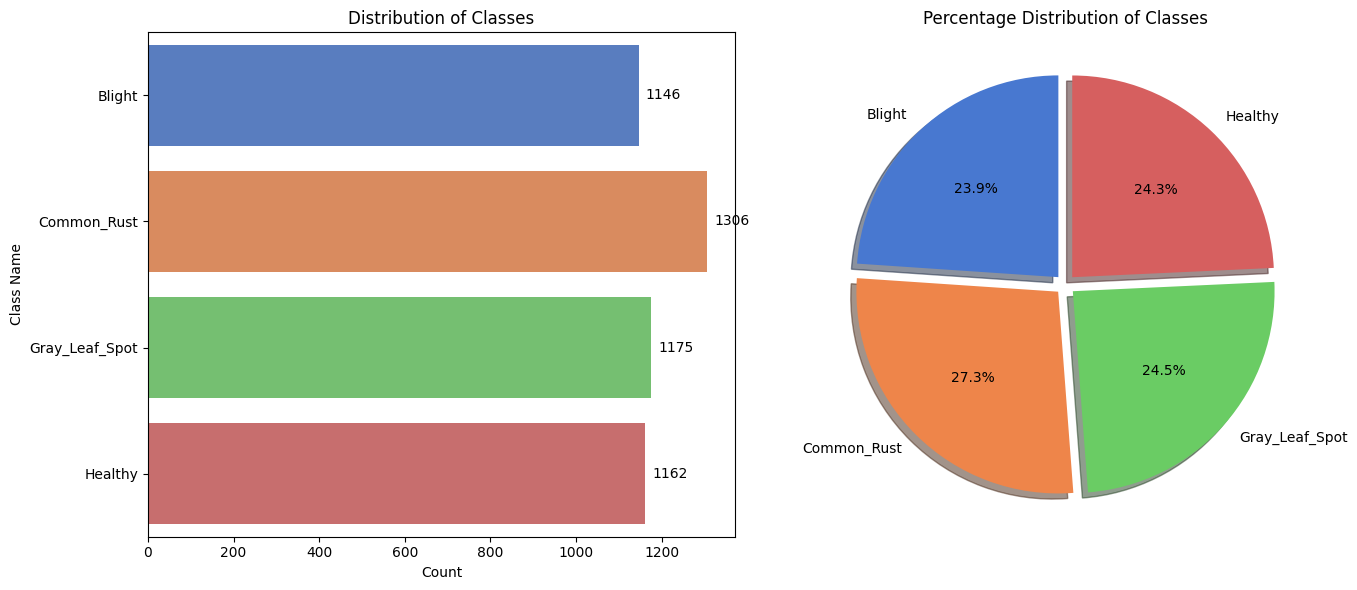

In [19]:
# Đếm số ảnh trong mỗi lớp
class_names = sorted(os.listdir(data_dir))
class_counts = []

for cls in class_names:
    cls_dir = os.path.join(data_dir, cls)
    num_images = len([img for img in os.listdir(cls_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_counts.append(num_images)

# Tạo DataFrame
df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))

# Biểu đồ thanh ngang
plt.subplot(1, 2, 1)
sns.barplot(y='Class', x='Count', data=df, palette='muted')
plt.title('Distribution of Classes')
plt.xlabel('Count')
plt.ylabel('Class Name')

# Thêm số lên cột
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Biểu đồ tròn
plt.subplot(1, 2, 2)
df.set_index('Class')['Count'].plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('muted'),
    startangle=90,
    explode=[0.05]*len(df),
    shadow=True
)
plt.title('Percentage Distribution of Classes')
plt.ylabel('')

plt.tight_layout()
plt.show()


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Chia tập train,test,valid</p>

In [20]:
# Thư mục đích để chứa train/valid/test 
output_dir = "/kaggle/working/split_data"
os.makedirs(output_dir, exist_ok=True)

# Tỷ lệ chia
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Ánh xạ tên lớp gốc sang tiếng Việt
rename_map = {
    "Blight": "chay-la",
    "Common_Rust": "dom-la",
    "Gray_Leaf_Spot": "gi-sat",
    "Healthy": "khoe-manh"
}

# Chia và copy ảnh
for old_cls_name, new_cls_name in rename_map.items():
    cls_dir = os.path.join(data_dir, old_cls_name)
    images = [img for img in os.listdir(cls_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_valid = int(n_total * valid_ratio)

    splits = {
        "train": images[:n_train],
        "valid": images[n_train:n_train + n_valid],
        "test": images[n_train + n_valid:]
    }

    for split_name, split_images in splits.items():
        split_dir = os.path.join(output_dir, split_name, new_cls_name)  # dùng tên mới
        os.makedirs(split_dir, exist_ok=True)
        for img_name in split_images:
            src = os.path.join(cls_dir, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copy2(src, dst)

print("Dữ liệu đã được chia tại thư mục:", output_dir)


Dữ liệu đã được chia tại thư mục: /kaggle/working/split_data


In [21]:
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "valid")
test_dir = os.path.join(output_dir, "test")

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Chúng ta sẽ sử dụng hàm <code>image_dataset_from_directory</code> của TensorFlow, để tải hình ảnh từ các thư mục dưới dạng <b>TensorFlow Dataset</b> sau có thể xử lý để chia lô (batching), xáo trộn (shuffling), tăng cường (augmenting) và thực hiện một số bước tiền xử lý khác.</p>

In [22]:
# Tạo tập dữ liệu huấn luyện (train)
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',  # Nhãn sẽ được mã hóa one-hot
    batch_size = 16,  # Kích thước mỗi lô (batch) ảnh đưa vào mô hình
    image_size = (256, 256),  # Kích thước cố định cho tất cả ảnh (resize về 256x256)
    shuffle = True,  # Xáo trộn dữ liệu mỗi lần lặp (epoch)
    seed = seed,  # Đặt seed để việc xáo trộn được tái lặp
    validation_split = 0, 
    crop_to_aspect_ratio = True  # Cắt ảnh để giữ tỉ lệ khung hình, tránh méo hình
)


Found 3351 files belonging to 4 classes.


In [23]:
# Tạo tập dữ liệu kiểm tra (test)
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',  # Mã hóa nhãn dưới dạng one-hot
    batch_size = 16,  # Kích thước mỗi lô (batch) dữ liệu
    image_size = (256, 256),  # Resize ảnh về kích thước cố định 256x256 pixel
    shuffle = False,  # Xáo trộn thứ tự ảnh trước khi đưa vào mô hình
    seed = seed,  # Đặt seed để đảm bảo việc xáo trộn là có thể tái lặp
    validation_split = 0,
    crop_to_aspect_ratio = True  # Cắt ảnh để giữ nguyên tỉ lệ khung hình 
)


Found 722 files belonging to 4 classes.


In [24]:
# Tạo tập dữ liệu kiểm định (validation)
validation = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels = 'inferred',
    label_mode = 'categorical',  # Mã hóa nhãn theo dạng one-hot
    batch_size = 16,  # Số lượng ảnh trong mỗi lô dữ liệu
    image_size = (256, 256),  # Resize ảnh về kích thước cố định 256x256 pixel
    shuffle = True,  # Xáo trộn thứ tự ảnh trước khi đưa vào mô hình
    seed = seed,  # Đặt seed để đảm bảo quá trình xáo trộn là ngẫu nhiên nhưng có thể tái lặp
    validation_split = 0,
    crop_to_aspect_ratio = True  # Cắt ảnh để giữ đúng tỉ lệ khung hình ban đầu 
)


Found 716 files belonging to 4 classes.


<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Một bước quan trọng khác trong quá trình tiền xử lý là đảm bảo rằng các giá trị điểm ảnh của hình ảnh nằm trong khoảng từ 0 đến 1. Phương thức <code>image_dataset_from_directory</code> đã thực hiện một số phép biến đổi, nhưng các giá trị điểm ảnh vẫn nằm trong khoảng từ 0 đến 255.</p>

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Để đưa các giá trị điểm ảnh vào khoảng từ 0 đến 1, chúng ta có thể sử dụng <code>Rescaling</code>.</p>

In [25]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [26]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Bây giờ chúng ta có thể một lần nữa trực quan hóa giá trị điểm ảnh tối thiểu và tối đa</p>

In [27]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


# Data visualization(Trực quan hoá dữ liệu)

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Số lượng ảnh trong tập dữ liệu</p>

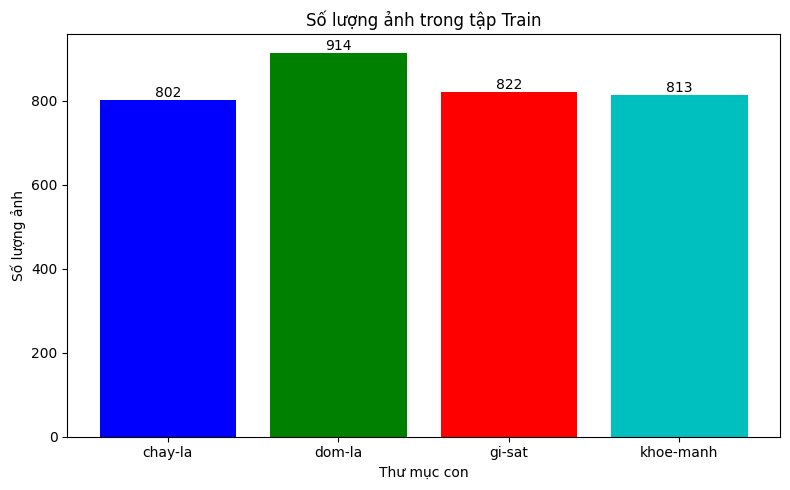

In [28]:
train_dir = '/kaggle/working/split_data/train'
test_dir = '/kaggle/working/split_data/test'
val_dir = '/kaggle/working/split_data/valid'

subfolders = ['chay-la', 'dom-la', 'gi-sat', 'khoe-manh']

def plot_image_distribution(directory, set_name):
    subfolder_names = []
    image_counts = []

    # Đếm ảnh trong các nhãn
    for sub in subfolders:
        path = os.path.join(directory, sub)
        num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        subfolder_names.append(sub)
        image_counts.append(num_files)

    plt.figure(figsize=(8, 5))

    bars = plt.bar(subfolder_names, image_counts, color=['b', 'g', 'r', 'c'])

    plt.xlabel('Thư mục con')
    plt.ylabel('Số lượng ảnh')
    plt.title(f'Số lượng ảnh trong tập {set_name}')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_image_distribution(train_dir, 'Train')


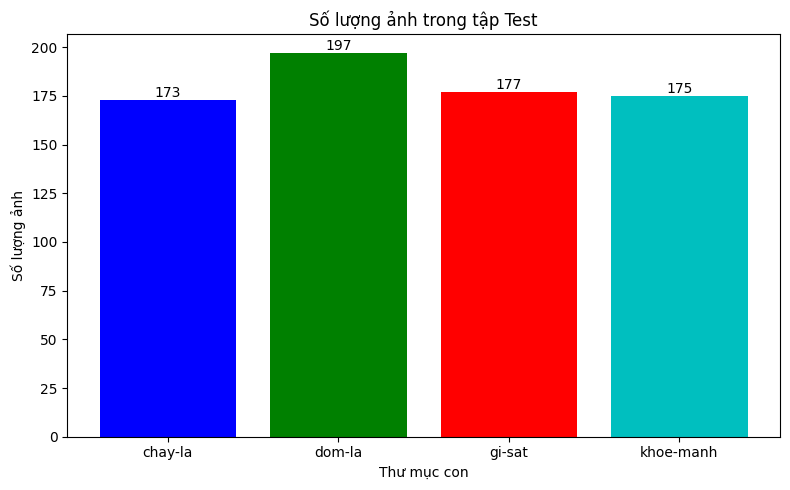

In [29]:
plot_image_distribution(test_dir, 'Test')

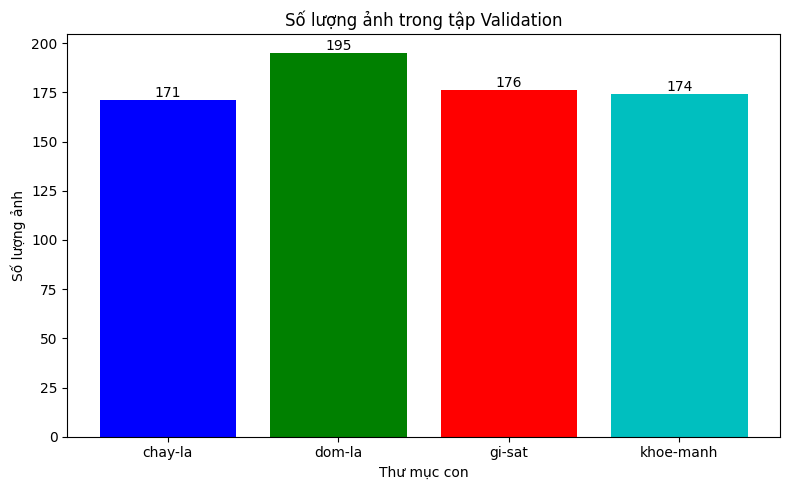

In [30]:
plot_image_distribution(val_dir, 'Validation')

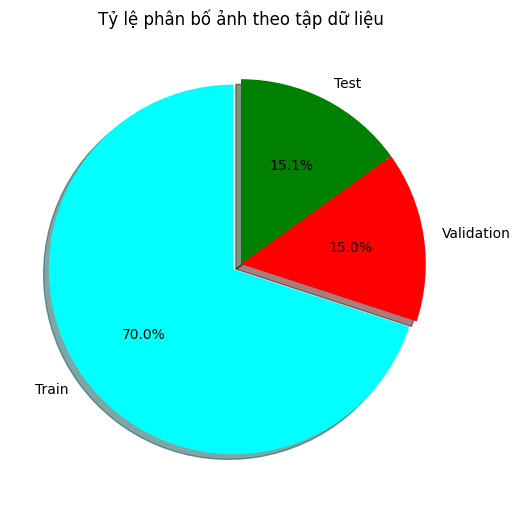

In [31]:
# Đếm số lượng ảnh trong từng tập
def count_images(split_dir):
    total = 0
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        total += len([f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
    return total

train_count = count_images(os.path.join(train_dir))
valid_count = count_images(os.path.join(valid_dir))
test_count  = count_images(os.path.join(test_dir))

# Dữ liệu để vẽ
counts = [train_count, valid_count, test_count]
labels = ['Train', 'Validation', 'Test']
colors = ['aqua', 'red', 'green']

# Vẽ biểu đồ
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%.1f%%', colors=colors, explode=(0.05, 0, 0), shadow=True, startangle=90)
plt.title("Tỷ lệ phân bố ảnh theo tập dữ liệu")

# Lưu trước khi hiển thị
plt.savefig('dataset_pie.png')
plt.show()


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Hiển thị ảnh cây ngô có tình trạng bệnh cháy lá</p>

In [32]:
# Hàm hiển thị hình ảnh từ danh sách trong dạng ma trận
def plot_images_list(images, title, subtitle):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(f'{title}\n{subtitle}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

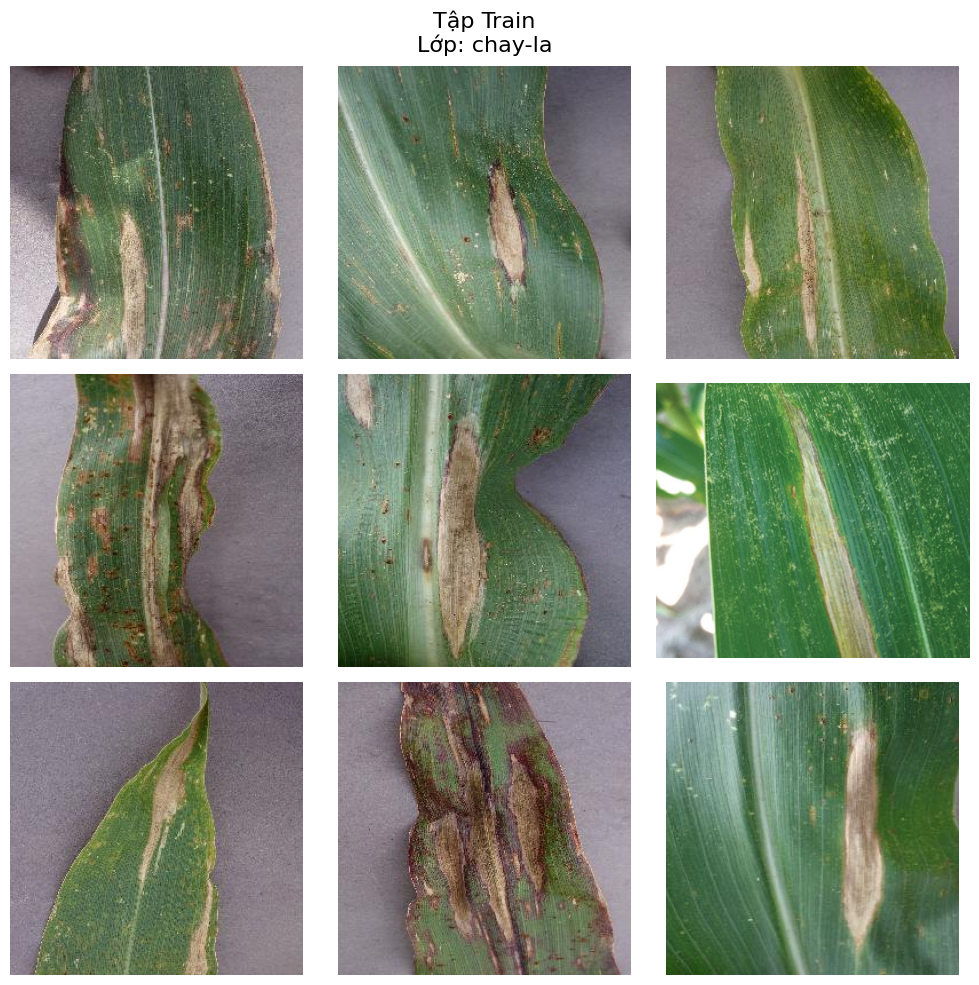

In [34]:
# Lấy ảnh từ thư mục train/chay-la
cls_name = "chay-la"
split = "train"
image_dir = f"/kaggle/working/split_data/{split}/{cls_name}"

# Lấy ngẫu nhiên 9 ảnh
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)
sample_images = image_files[:9]

# Đọc ảnh
images = [mpimg.imread(img_path) for img_path in sample_images]

# Hiển thị
plot_images_list(images, title=f"Tập {split.capitalize()}", subtitle=f"Lớp: {cls_name}")


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Hiển thị ảnh cây ngô có tình trạng bệnh đốm lá</p>

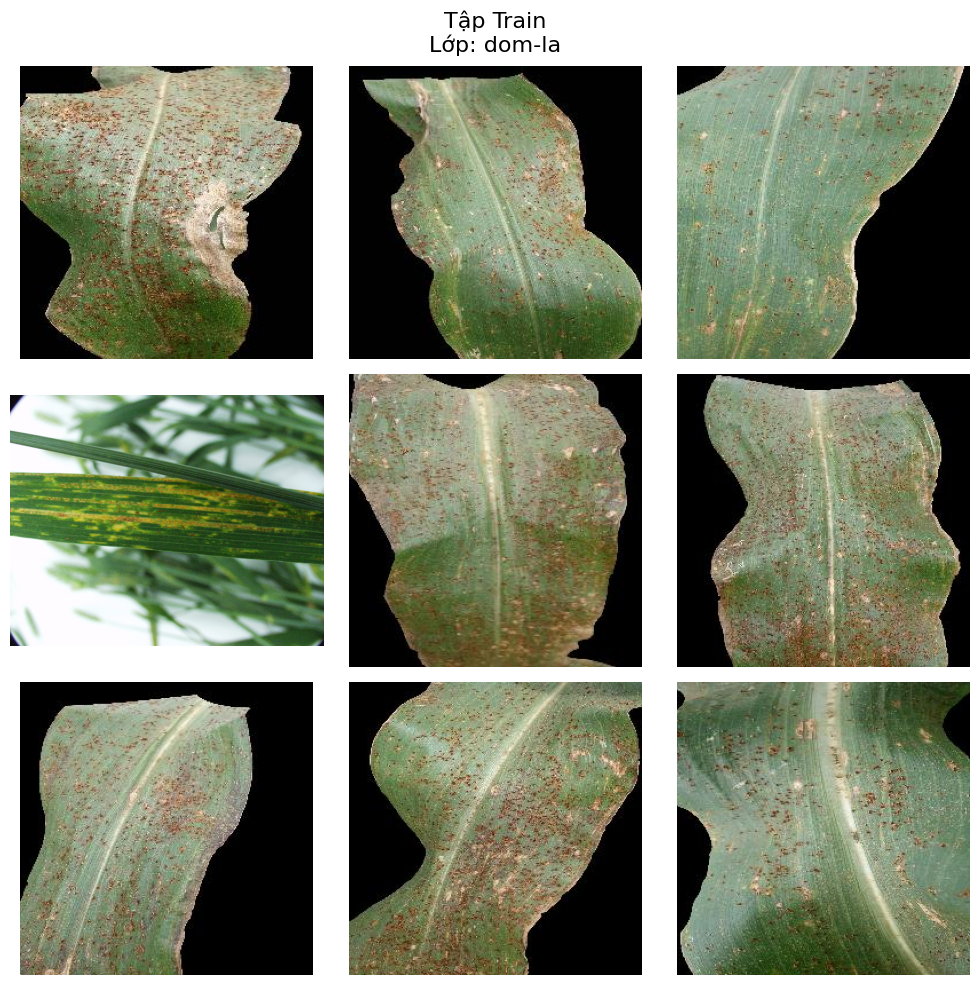

In [35]:
# Lấy ảnh từ thư mục train/chay-la
cls_name = "dom-la"
split = "train"
image_dir = f"/kaggle/working/split_data/{split}/{cls_name}"

# Lấy ngẫu nhiên 9 ảnh
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)
sample_images = image_files[:9]

# Đọc ảnh
images = [mpimg.imread(img_path) for img_path in sample_images]

# Hiển thị
plot_images_list(images, title=f"Tập {split.capitalize()}", subtitle=f"Lớp: {cls_name}")


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Hiển thị ảnh cây ngô có tình trạng bệnh gỉ sắt</p>

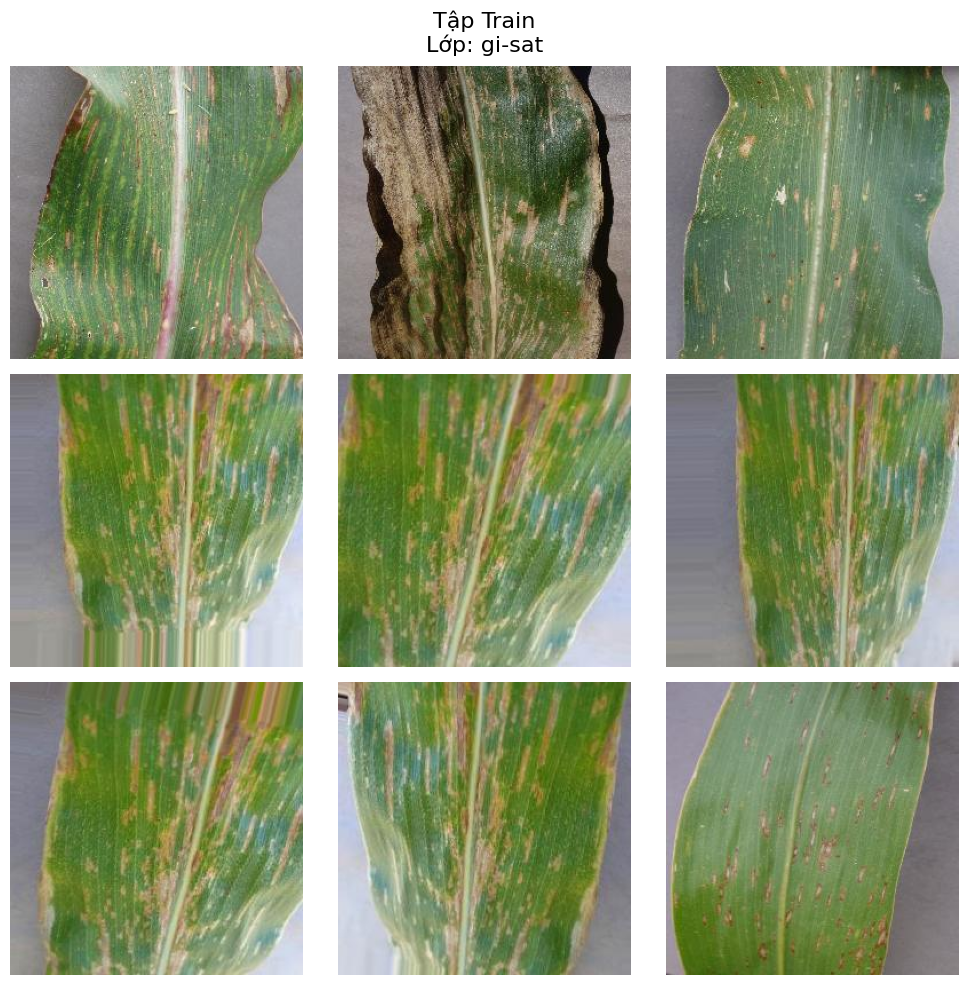

In [36]:
# Lấy ảnh từ thư mục train/chay-la
cls_name = "gi-sat"
split = "train"
image_dir = f"/kaggle/working/split_data/{split}/{cls_name}"

# Lấy ngẫu nhiên 9 ảnh
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)
sample_images = image_files[:9]

# Đọc ảnh
images = [mpimg.imread(img_path) for img_path in sample_images]

# Hiển thị
plot_images_list(images, title=f"Tập {split.capitalize()}", subtitle=f"Lớp: {cls_name}")


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Hiển thị ảnh cây ngô có tình trạng khoẻ mạnh</p>

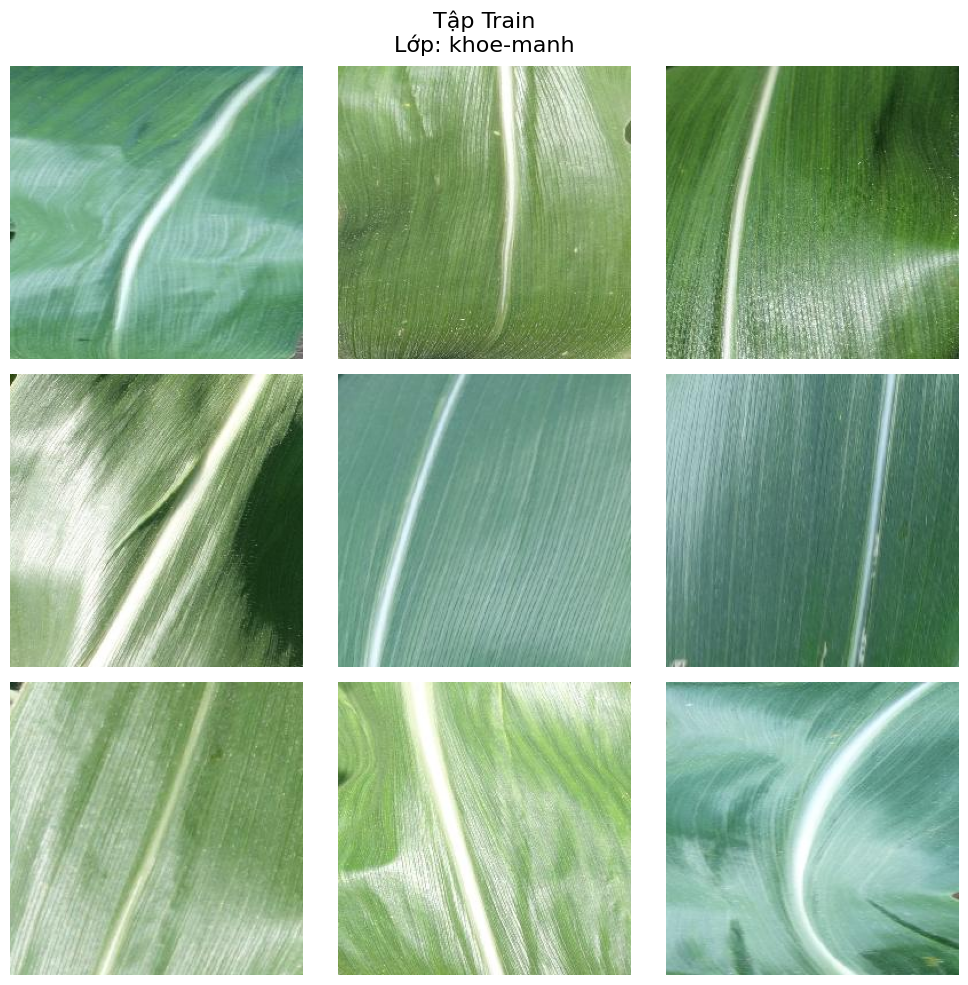

In [37]:
# Lấy ảnh từ thư mục train/chay-la
cls_name = "khoe-manh"
split = "train"
image_dir = f"/kaggle/working/split_data/{split}/{cls_name}"

# Lấy ngẫu nhiên 9 ảnh
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)
sample_images = image_files[:9]

# Đọc ảnh
images = [mpimg.imread(img_path) for img_path in sample_images]

# Hiển thị
plot_images_list(images, title=f"Tập {split.capitalize()}", subtitle=f"Lớp: {cls_name}")


# Building the Convolutional Neural Network (Xây dựng Mạng Nơ-ron Tích chập)

In [39]:
# Khởi tạo mô hình Sequential (mô hình tuần tự - lớp sau nối tiếp lớp trước)
model = Sequential()

# ====== Các lớp trích xuất đặc trưng (Feature Learning Layers) ======

# Lớp tích chập 1 (Conv2D): 32 bộ lọc kích thước 3x3, bước trượt 1, padding để giữ nguyên kích thước ảnh
model.add(Conv2D(32, (3,3), strides=1, padding='same', input_shape=(256, 256, 3)))  # Ảnh đầu vào có kích thước 256x256, 3 kênh màu (RGB)
model.add(Activation('relu'))                 # Hàm kích hoạt ReLU giúp mô hình học phi tuyến tính
model.add(BatchNormalization())               # Chuẩn hóa đầu ra để tăng tốc học và ổn định mô hình
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))  # Lấy giá trị lớn nhất trong vùng 2x2 (giảm chiều ảnh)
model.add(Dropout(0.2))                        # Bỏ ngẫu nhiên 20% số node để tránh overfitting

# Lớp tích chập 2
model.add(Conv2D(64, (5,5), padding='same'))  # Tăng số bộ lọc lên 64, kernel lớn hơn
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))

# Lớp tích chập 3
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.3))

# Lớp tích chập 4
model.add(Conv2D(256, (5,5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.3))

# Lớp tích chập 5
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.3))

# ====== Chuyển đổi tensor thành vector (Flattening) ======
model.add(Flatten())  # Làm phẳng đầu ra từ các lớp convolution/pooling để đưa vào lớp fully connected

# ====== Các lớp fully-connected ======

model.add(Dense(2048))            # Lớp dense với 2048 node
model.add(Activation('relu'))     # Hàm kích hoạt ReLU
model.add(Dropout(0.5))           # Dropout 50% giúp giảm overfitting

# ====== Lớp đầu ra (Output Layer) ======
model.add(Dense(4, activation='softmax'))  # Lớp đầu ra với 4 lớp phân loại, dùng softmax để tạo xác suất

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Chúng ta sẽ xây dựng một mạng Nơ-ron Tích chập (CNN) bằng cách sử dụng lớp <code>Sequential</code> trong Keras. Đây là một mô hình tuyến tính, nơi mỗi lớp là đầu vào cho lớp kế tiếp. Mô hình của chúng ta sẽ bao gồm các lớp <b>Convolutional</b>, <b>BatchNormalization</b>, <b>Pooling</b>, <b>Dropout</b> và <b>Fully-Connected</b>.</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• Conv2D</b>: Áp dụng các bộ lọc tích chập để trích xuất đặc trưng từ ảnh đầu vào. Chúng em sử dụng nhiều kích thước kernel như <code>3x3</code> và <code>5x5</code> để học các đặc trưng ở nhiều cấp độ khác nhau.</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• BatchNormalization</b>: Chuẩn hóa đầu ra để ổn định và tăng tốc quá trình học.</p> <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• MaxPooling2D</b>: Giảm kích thước không gian của đặc trưng, đồng thời giữ lại thông tin quan trọng.</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• Dropout</b>: Ngăn ngừa overfitting bằng cách ngẫu nhiên loại bỏ các neuron trong quá trình huấn luyện.</p> <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• Flatten</b>: Chuyển đổi tensor nhiều chiều thành vector để đưa vào các lớp Dense.</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• Dense</b>: Các lớp fully-connected giúp học các mối quan hệ phi tuyến giữa các đặc trưng đã trích xuất.</p> </div> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Mạng CNN này có khả năng học các đặc trưng ở nhiều cấp độ và phù hợp với các bài toán phân loại hình ảnh đa lớp (4 lớp đầu ra sử dụng <code>softmax</code>).</p>

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Bằng cách sử dụng phương thức <code>compile</code> của Keras, chúng ta có thể chuẩn bị mạng nơ-ron của mình cho quá trình huấn luyện. Phương thức này có một số tham số, và những tham số mà chúng ta sẽ tập trung vào ở đây là:</p>

<div style="margin-left: 25px;">

  <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• optimizer</b>: Tham số này định nghĩa các thuật toán để điều chỉnh các cập nhật trọng số. Đây là một tham số quan trọng, vì việc chọn đúng bộ tối ưu hóa rất cần thiết để tăng tốc quá trình hội tụ. Chúng ta sẽ sử dụng <code>RMSprop</code>, là bộ tối ưu hóa .</p>

  <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• loss</b>: Đây là hàm mất mát mà chúng ta cố gắng tối thiểu hóa trong quá trình huấn luyện. Trong trường hợp này, chúng ta sử dụng <code>categorical_crossentropy</code>, là một lựa chọn tốt cho các bài toán phân loại với hơn hai lớp.</p>

  <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"><b>• metrics</b>: Tham số này định nghĩa chỉ số sẽ được sử dụng để đánh giá hiệu suất trong quá trình huấn luyện và xác nhận. Vì dữ liệu của chúng ta không bị mất cân bằng nhiều, chúng ta có thể sử dụng <code>accuracy</code> cho mục đích này, đây là một chỉ số rất đơn giản được tính theo công thức sau:</p>

  <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">
  \begin{equation}
  \text{Accuracy} = \frac{\text{Số lượng dự đoán chính xác}}{\text{Tổng số dự đoán}}
  \end{equation}
  </p>
</div>

In [40]:
# Compiling model
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(0.0001),       # Trình tối ưu hóa RMSprop với learning rate = 0.0001
    loss = 'categorical_crossentropy',                     # Hàm mất mát dùng cho bài toán phân loại đa lớp (nhãn one-hot)
    metrics = ['accuracy']                                 # Đánh giá mô hình dựa trên độ chính xác (accuracy)
)


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Sau khi biên dịch mô hình, chúng ta sẽ định nghĩa một <b>Early Stopping</b> và một <b>Model Checkpoint</b>.</p> <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Early Stopping có mục đích ngừng quá trình huấn luyện khi một chỉ số nhất định không cải thiện trong một khoảng thời gian. Trong trường hợp này, chúng em sẽ cấu hình phương thức <code>EarlyStopping</code> để giám sát độ chính xác trên bộ kiểm tra, và dừng quá trình huấn luyện nếu không có sự cải thiện nào sau 20 epoch.</p> <p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Model Checkpoint sẽ đảm bảo rằng chỉ có các trọng số tốt nhất được lưu lại, và chúng ta cũng sẽ định nghĩa <i>trọng số tốt nhất</i> dựa trên độ chính xác của mô hình trên bộ kiểm tra.</p>

In [41]:
# Callback dừng huấn luyện sớm nếu độ chính xác trên tập validation không cải thiện sau 10 epoch
early_stopping = EarlyStopping(
    monitor='val_accuracy',             # Theo dõi độ chính xác trên tập validation
    patience=20,                        # Số epoch chờ cải thiện trước khi dừng
    mode='max',                         # Tối đa hóa giá trị val_accuracy
    restore_best_weights=True          # Khôi phục trọng số của mô hình tốt nhất (cao nhất) khi kết thúc huấn luyện
)

# Callback lưu lại mô hình có độ chính xác trên validation cao nhất
checkpoint = ModelCheckpoint(
    'best_model.keras',                # Tên file để lưu mô hình tốt nhất
    monitor='val_accuracy',            # Theo dõi độ chính xác trên tập validation
    save_best_only=True                # Chỉ lưu mô hình khi độ chính xác tốt hơn các lần trước
)


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Bây giờ chúng ta có thể sử dụng <code>model.fit()</code> để bắt đầu quá trình huấn luyện và kiểm tra.</p>

In [42]:
try:
    history = model.fit(
        train, epochs=100, 
        validation_data=validation, 
        callbacks=[early_stopping, checkpoint]
    )
except Exception as e:
    print("An error occurred during training:")
    print(traceback.format_exc())


Epoch 1/100


I0000 00:00:1748270456.514677      94 service.cc:148] XLA service 0x7d2c4c003b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748270456.516265      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748270457.187456      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/210 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.1719 - loss: 6.3030 

I0000 00:00:1748270468.515926      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.7085 - loss: 4.4043 - val_accuracy: 0.3422 - val_loss: 5.9761
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.8318 - loss: 1.0601 - val_accuracy: 0.3366 - val_loss: 6.1314
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8631 - loss: 0.6592 - val_accuracy: 0.7709 - val_loss: 1.6316
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8960 - loss: 0.4139 - val_accuracy: 0.8659 - val_loss: 1.1779
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9084 - loss: 0.3708 - val_accuracy: 0.8659 - val_loss: 1.0814
Epoch 6/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9244 - loss: 0.3255 - val_accuracy: 0.8310 - val_loss: 1.6307
Epoch 7/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9420 - loss: 0.2332 - val_accuracy: 0.7891 - val_loss: 2.3159
Epoch 8/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9486 - loss: 0.1872 - val

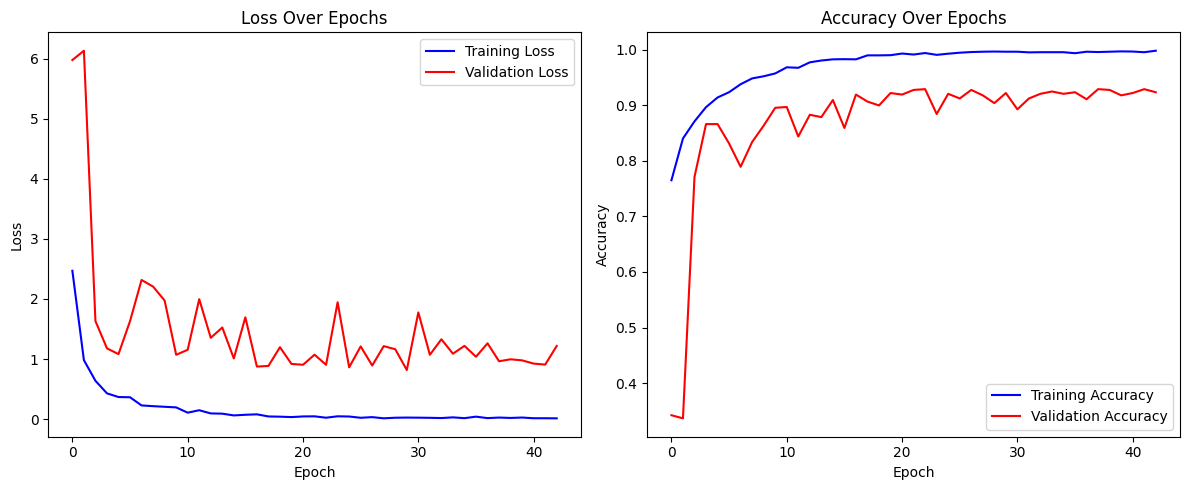

In [43]:
# Loss over epochs
plt.figure(figsize=(12, 5))

# Tạo đồ thị Loss
plt.subplot(1, 2, 1)  # Chia thành 2 biểu đồ
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy over epochs
plt.subplot(1, 2, 2)  # Biểu đồ thứ 2
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

<p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;">Nhận xét</p>
          
<div style="margin-left: 25px;">
    
  <p style="font-family: Calibri, serif; text-align: left;
    font-size: 24px; letter-spacing: .85px;"><b>• Training Loss:</b> Giảm rất nhanh trong 10 epoch đầu, gần như tiệm cận về 0 sau khoảng 30 epoch. Điều này cho thấy mô hình học rất tốt trên dữ liệu huấn luyện </p>
    
   <p style="font-family: Calibri, serif; text-align: left;
    font-size: 24px; letter-spacing: .85px;"><b>• Validation Loss :</b> Ban đầu cao nhưng giảm nhanh chóng trong vài epoch đầu. Sau đó dao động nhẹ quanh mức thấp, không tăng rõ rệt </p>

  <p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;"><b>• Training Accuracy:</b> Tăng đều từ 0.75 → gần 1.0 trong khoảng 25 epoch đầu. Sau đó duy trì ổn định gần 100% </p>
    
  <p style="font-family: Calibri, serif; text-align: left;
          font-size: 24px; letter-spacing: .85px;"><b>• Validation Accuracy:</b> Bắt đầu từ ~0.25 nhưng tăng mạnh, đạt ~0.9 và giữ ổn định. Dao động nhỏ, không có hiện tượng tụt giảm mạnh</p>
</div>



<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Sử dụng <code>model.summary()</code>, chúng ta có thể trích xuất thêm thông tin về cấu trúc của mạng nơ-ron.</p>

In [45]:
model.summary() # Printing model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,495,434 (528.32 MB)

 Trainable params: 69,246,724 (264.16 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 69,246,726 (264.16 MB)

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Ta thấy mô hình CNN có cấu trúc:</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">- 5 khối Conv2D → Activation → BatchNorm → MaxPooling → Dropout</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">- Sau đó là Flatten → Dense (2048) → Dropout → Dense (output = 4 classes)</p> 

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Chúng ta cũng có thể thấy rằng mô hình có hơn 69 triệu tham số có thể huấn luyện. Các tham số không thể huấn luyện là các tham số từ các lớp BatchNormalization.</p>

# Validating Performance (Kiểm tra hiệu suất)

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Sau khi hoàn thành giai đoạn huấn luyện và kiểm tra, chúng ta có thể tiếp tục và xác nhận mô hình của mình trên bộ xác nhận (validation). Để tải các trọng số tốt nhất đạt được trong quá trình huấn luyện, chúng ta chỉ cần sử dụng phương thức <code>load_weights</code>. Các trọng số này sẽ được lưu với cùng tên mà chúng ta đã đặt trong cấu hình <code>ModelCheckpoint</code>, khi chúng ta thiết lập <code>ModelCheckpoint('best_model.h5')</code>.</p>

In [46]:
# Loading best weights
model.load_weights('best_model.keras')

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Accuracy Score</p>

In [50]:
# Đánh giá mô hình
train_loss, train_acc = model.evaluate(train)
test_loss, test_acc = model.evaluate(test)
val_loss, val_acc = model.evaluate(validation)

print('\nTrain Loss: ', train_loss)                     
print('\nTrain Accuracy: ', np.round(train_acc * 100), '%')

print('\nTest Loss: ', test_loss)                     
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')

print('\nValidation Loss: ', val_loss)                     
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9842 - loss: 0.1055
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9008 - loss: 1.2247
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9290 - loss: 0.9678

Train Loss:  0.0968424379825592

Train Accuracy:  98.0 %

Test Loss:  0.9531589150428772

Test Accuracy:  92.0 %

Validation Loss:  0.9037333130836487

Validation Accuracy:  93.0 %


<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Mô hình đã dự đoán chính xác $93$% các nhãn của các hình ảnh trong tập validation.</p>

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Classification Report</p>

In [54]:
# Lấy tên lớp
class_names = sorted(entry.name for entry in os.scandir(test_dir) if entry.is_dir())

# Gom toàn bộ ảnh và nhãn trong tập test thành một mảng
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))           # lấy nhãn dự đoán
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # lấy nhãn thật (one-hot -> index)

# In classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;"> Độ chính xác tổng thể (accuracy): 92% trên 722 mẫu test.</p> 
<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">- khoe-manh: Hoạt động tốt nhất, recall = 1.00 → mô hình không bỏ sót ảnh nào thuộc lớp này. </p>
<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">- dom-la & gi-sat: F1-score cao > 0.90 → mô hình phân biệt tốt.</p>
<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">- chay-la: Có precision thấp nhất (0.83) → có vẻ mô hình hay nhầm lẫn các ảnh khác là chay-la, nhưng recall cao → đã tìm ra hầu hết ảnh đúng chay-la.</p>

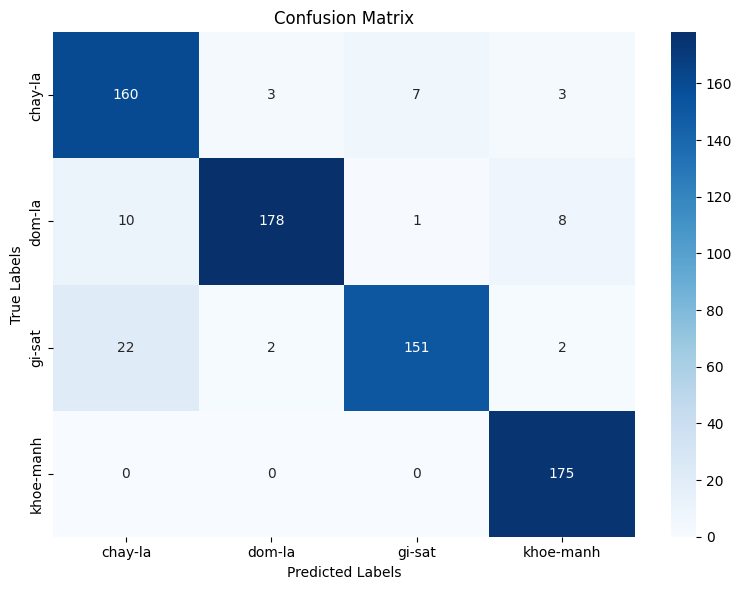

In [66]:
# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

<p style="font-family: Calibri, serif; text-align: left; font-size: 24px; letter-spacing: .85px;">Tiếp theo, chúng em sẽ tải một số hình ảnh từ tập validation và chạy các dự đoán trên chúng một cách riêng lẻ, để chúng ta có thể quan sát cách mà mô hình hoạt động với từng hình ảnh cụ thể.</p>

Đường dẫn ảnh gốc: /kaggle/working/split_data/valid/chay-la/Corn_Blight (650).jpg
Kích thước ảnh gốc: 256x256


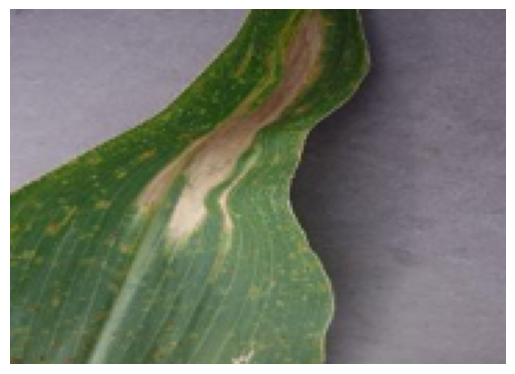

Ảnh bệnh cháy lá:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicted Class: chay-la
Confidence Score: 1.0
Nhãn thực tế của ảnh: chay-la
Dự đoán chính xác!


In [61]:
directory_path = '/kaggle/working/split_data/valid/chay-la'

# Lấy danh sách tất cả các ảnh trong thư mục
image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Kiểm tra nếu thư mục không chứa ảnh
if not image_files:
    print(f"Thư mục {directory_path} không chứa ảnh.")
else:
    # Chọn ngẫu nhiên một ảnh từ thư mục
    random_image = random.choice(image_files)
    image_path = os.path.join(directory_path, random_image)

    # Tải ảnh gốc
    original_image = Image.open(image_path)
    og_width, og_height = original_image.size
    print(f"Đường dẫn ảnh gốc: {image_path}")
    print(f"Kích thước ảnh gốc: {og_width}x{og_height}")

    # Resize ảnh cho phù hợp với mô hình (50% kích thước gốc cho tối ưu hiệu suất)
    new_width = int(og_width * 0.70)
    new_height = int(og_height * 0.50)
    resized_img = original_image.resize((new_width, new_height))

    # Hiển thị ảnh resized bằng matplotlib
    plt.imshow(resized_img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    print("Ảnh bệnh cháy lá:")

    # Tiền xử lý ảnh (resize về 256x256 và chuẩn hóa)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0  # Chuẩn hóa ảnh

    # Dự đoán nhãn của ảnh
    preds = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Các nhãn tương ứng với các lớp của mô hình
    labels = ['chay-la', 'dom-la','gi-sat','khoe-manh']

    # Tìm lớp có xác suất cao nhất
    preds_class = np.argmax(preds)
    preds_label = labels[preds_class]

    # Lấy nhãn thực tế từ tên thư mục chứa ảnh
    true_label = directory_path.split('/')[-1]  # Lấy tên thư mục làm nhãn thực tế

    # In ra kết quả dự đoán và nhãn thực tế
    print(f'\nPredicted Class: {preds_label}')
    print(f'Confidence Score: {preds[0][preds_class]}')
    print(f'Nhãn thực tế của ảnh: {true_label}')

    # So sánh kết quả
    if preds_label == true_label:
        print("Dự đoán chính xác!")
    else:
        print("Dự đoán sai.")


Đường dẫn ảnh gốc: /kaggle/working/split_data/valid/dom-la/Corn_Common_Rust (1294).jpg
Kích thước ảnh gốc: 2848x4272


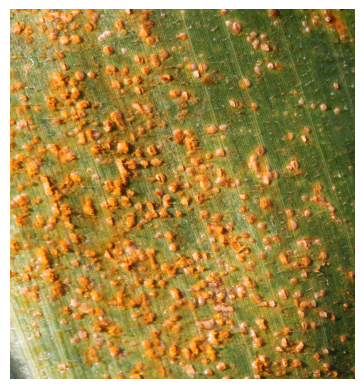

Ảnh bệnh đốm lá:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicted Class: dom-la
Confidence Score: 1.0
Nhãn thực tế của ảnh: dom-la
Dự đoán chính xác!


In [62]:
directory_path = '/kaggle/working/split_data/valid/dom-la'

# Lấy danh sách tất cả các ảnh trong thư mục
image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Kiểm tra nếu thư mục không chứa ảnh
if not image_files:
    print(f"Thư mục {directory_path} không chứa ảnh.")
else:
    # Chọn ngẫu nhiên một ảnh từ thư mục
    random_image = random.choice(image_files)
    image_path = os.path.join(directory_path, random_image)

    # Tải ảnh gốc
    original_image = Image.open(image_path)
    og_width, og_height = original_image.size
    print(f"Đường dẫn ảnh gốc: {image_path}")
    print(f"Kích thước ảnh gốc: {og_width}x{og_height}")

    # Resize ảnh cho phù hợp với mô hình (50% kích thước gốc cho tối ưu hiệu suất)
    new_width = int(og_width * 0.70)
    new_height = int(og_height * 0.50)
    resized_img = original_image.resize((new_width, new_height))

    # Hiển thị ảnh resized bằng matplotlib
    plt.imshow(resized_img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    print("Ảnh bệnh đốm lá:")

    # Tiền xử lý ảnh (resize về 256x256 và chuẩn hóa)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0  # Chuẩn hóa ảnh

    # Dự đoán nhãn của ảnh
    preds = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Các nhãn tương ứng với các lớp của mô hình
    labels = ['chay-la', 'dom-la','gi-sat','khoe-manh']

    # Tìm lớp có xác suất cao nhất
    preds_class = np.argmax(preds)
    preds_label = labels[preds_class]

    # Lấy nhãn thực tế từ tên thư mục chứa ảnh
    true_label = directory_path.split('/')[-1]  # Lấy tên thư mục làm nhãn thực tế

    # In ra kết quả dự đoán và nhãn thực tế
    print(f'\nPredicted Class: {preds_label}')
    print(f'Confidence Score: {preds[0][preds_class]}')
    print(f'Nhãn thực tế của ảnh: {true_label}')

    # So sánh kết quả
    if preds_label == true_label:
        print("Dự đoán chính xác!")
    else:
        print("Dự đoán sai.")


Đường dẫn ảnh gốc: /kaggle/working/split_data/valid/gi-sat/Corn_Gray_Spot (335).jpg
Kích thước ảnh gốc: 256x256


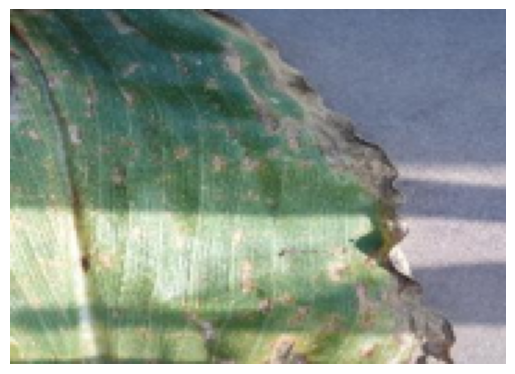

Ảnh bệnh gỉ sắt:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Predicted Class: chay-la
Confidence Score: 0.9999998807907104
Nhãn thực tế của ảnh: gi-sat
Dự đoán sai.


In [63]:
directory_path = '/kaggle/working/split_data/valid/gi-sat'

# Lấy danh sách tất cả các ảnh trong thư mục
image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Kiểm tra nếu thư mục không chứa ảnh
if not image_files:
    print(f"Thư mục {directory_path} không chứa ảnh.")
else:
    # Chọn ngẫu nhiên một ảnh từ thư mục
    random_image = random.choice(image_files)
    image_path = os.path.join(directory_path, random_image)

    # Tải ảnh gốc
    original_image = Image.open(image_path)
    og_width, og_height = original_image.size
    print(f"Đường dẫn ảnh gốc: {image_path}")
    print(f"Kích thước ảnh gốc: {og_width}x{og_height}")

    # Resize ảnh cho phù hợp với mô hình (50% kích thước gốc cho tối ưu hiệu suất)
    new_width = int(og_width * 0.70)
    new_height = int(og_height * 0.50)
    resized_img = original_image.resize((new_width, new_height))

    # Hiển thị ảnh resized bằng matplotlib
    plt.imshow(resized_img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    print("Ảnh bệnh gỉ sắt:")

    # Tiền xử lý ảnh (resize về 256x256 và chuẩn hóa)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0  # Chuẩn hóa ảnh

    # Dự đoán nhãn của ảnh
    preds = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Các nhãn tương ứng với các lớp của mô hình
    labels = ['chay-la', 'dom-la','gi-sat','khoe-manh']

    # Tìm lớp có xác suất cao nhất
    preds_class = np.argmax(preds)
    preds_label = labels[preds_class]

    # Lấy nhãn thực tế từ tên thư mục chứa ảnh
    true_label = directory_path.split('/')[-1]  # Lấy tên thư mục làm nhãn thực tế

    # In ra kết quả dự đoán và nhãn thực tế
    print(f'\nPredicted Class: {preds_label}')
    print(f'Confidence Score: {preds[0][preds_class]}')
    print(f'Nhãn thực tế của ảnh: {true_label}')

    # So sánh kết quả
    if preds_label == true_label:
        print("Dự đoán chính xác!")
    else:
        print("Dự đoán sai.")


Đường dẫn ảnh gốc: /kaggle/working/split_data/valid/khoe-manh/Corn_Health (550).jpg
Kích thước ảnh gốc: 256x256


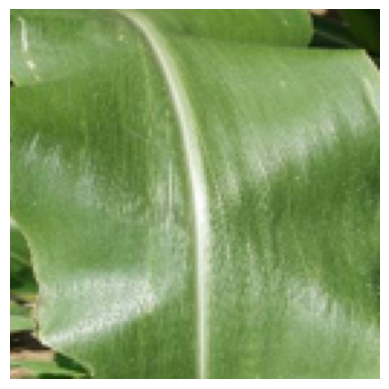

Ảnh cây khoẻ mạnh:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicted Class: khoe-manh
Confidence Score: 1.0
Nhãn thực tế của ảnh: khoe-manh
Dự đoán chính xác!


In [60]:
directory_path = '/kaggle/working/split_data/valid/khoe-manh'

# Lấy danh sách tất cả các ảnh trong thư mục
image_files = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Kiểm tra nếu thư mục không chứa ảnh
if not image_files:
    print(f"Thư mục {directory_path} không chứa ảnh.")
else:
    # Chọn ngẫu nhiên một ảnh từ thư mục
    random_image = random.choice(image_files)
    image_path = os.path.join(directory_path, random_image)

    # Tải ảnh gốc
    original_image = Image.open(image_path)
    og_width, og_height = original_image.size
    print(f"Đường dẫn ảnh gốc: {image_path}")
    print(f"Kích thước ảnh gốc: {og_width}x{og_height}")

    # Resize ảnh cho phù hợp với mô hình (50% kích thước gốc cho tối ưu hiệu suất)
    new_width = int(og_width * 0.50)
    new_height = int(og_height * 0.50)
    resized_img = original_image.resize((new_width, new_height))

    # Hiển thị ảnh resized bằng matplotlib
    plt.imshow(resized_img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    print("Ảnh cây khoẻ mạnh:")

    # Tiền xử lý ảnh (resize về 256x256 và chuẩn hóa)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0  # Chuẩn hóa ảnh

    # Dự đoán nhãn của ảnh
    preds = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Các nhãn tương ứng với các lớp của mô hình
    labels = ['chay-la', 'dom-la','gi-sat','khoe-manh']

    # Tìm lớp có xác suất cao nhất
    preds_class = np.argmax(preds)
    preds_label = labels[preds_class]

    # Lấy nhãn thực tế từ tên thư mục chứa ảnh
    true_label = directory_path.split('/')[-1]  # Lấy tên thư mục làm nhãn thực tế

    # In ra kết quả dự đoán và nhãn thực tế
    print(f'\nPredicted Class: {preds_label}')
    print(f'Confidence Score: {preds[0][preds_class]}')
    print(f'Nhãn thực tế của ảnh: {true_label}')

    # So sánh kết quả
    if preds_label == true_label:
        print("Dự đoán chính xác!")
    else:
        print("Dự đoán sai.")


In [64]:
model.save('plant_disease_classifier.h5') # Saving model